In [1]:
import re
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup  
import requests  
import json
import time 
from datetime import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


RANDOM_SEED = 42

# Parse data from the website

In [4]:
url = 'https://auto.ru/-/ajax/desktop/listing/'

In [5]:
headers = '''
Host: auto.ru
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:94.0) Gecko/20100101 Firefox/94.0
Accept: */*
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate, br
Referer: https://auto.ru/cars/used/?catalog_filter=mark%3DSKODA&catalog_filter=mark%3DBMW&catalog_filter=mark%3DVOLVO&catalog_filter=mark%3DHONDA&catalog_filter=mark%3DAUDI&year_from=1985&year_to=2020&page=4&cookiesync=true
x-client-app-version: 3e9f4c0d51b
x-page-request-id: e9bd320de3fd0dc0973e5c1e115bc6a6
x-client-date: 1636520899579
x-csrf-token: aeaa205bc2525bb0c99c98fc0c63cb7d946b76e427a54ea0
x-requested-with: fetch
content-type: application/json
Origin: https://auto.ru
Content-Length: 198
Connection: keep-alive
Cookie: _csrf_token=aeaa205bc2525bb0c99c98fc0c63cb7d946b76e427a54ea0; autoru_sid=a%3Ag618b53812rhl86sjtpetauv5vkmo6nl.d8487eec517020839a8354805eaccabb%7C1636520833100.604800.f5FptlxMzPxqRxJ8zTcnCw.2jYvP_IQD5SFy4Bnd3av--Ij6i92vHnu8g_uhOaQ0tM; autoruuid=g618b53812rhl86sjtpetauv5vkmo6nl.d8487eec517020839a8354805eaccabb; autoru_gdpr=1; suid=a71be49dafaf465d9e2c83931ba11a3c.e7f7b5cfe12884cd7d97a26279120dd0; from_lifetime=1636520896159; from=direct; X-Vertis-DC=vla; yuidlt=1; yandexuid=1793328871636520840; crookie=CzeZX1mvt6Otj2ihIyTd7/1g484edT2g/5k6JjIsG+B+qvLfNz5eO/HP1/6O0eluZoVnuet1LPdFLcW30TSm4qGSZEQ=; cmtchd=MTYzNjUyMDg1MzM0Mw==; deal_million_popup_page_seen=0; gdpr=0
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: same-origin
Sec-Fetch-Site: same-origin
'''.strip().split('\n')

dict_header = {}

for header in headers:
    key, value = header.split(': ')
    dict_header[key] = value

In [6]:
offers = []

In [7]:
#example 
for x in range(1, 5):
    
        parameters = {
        "catalog_filter": [
            {
                "mark": "SKODA"
            },
            {
                "mark": "BMW"
            },
            {
                "mark": "VOLVO"
            },
            {
                "mark": "HONDA"
            },
            {
                "mark": "AUDI"
            },
            {
                "mark": "NISSAN"
            },
            {
                "mark": "INFINITI"
            },
            {
                "mark": "MERCEDES"
            },
            {
                "mark": "TOYOTA"
            },
            {
                "mark": "LEXUS"
            },
            {
                "mark": "VOLKSWAGEN"
            },
            {
                "mark": "MITSUBISHI"
            }
        ],
        "category": "cars",
        "section": "used",
        "year_from": 1985,
        "year_to": 2021,
        "page": x

    }
        response = requests.post(url, json=parameters, headers=dict_header)
        data = response.json()
        offers.extend(data['offers'])
        print('current page: ', x)
        print('Waiting...')  
        time.sleep(0.5)

current page:  1
Waiting...
current page:  2
Waiting...
current page:  3
Waiting...
current page:  4
Waiting...


In [733]:
#with open('data.json', 'w') as f:
#    json.dump(offers, f)

In [9]:
with open('data.json', 'r', encoding='utf8') as f:
    data = json.load(f)
print(len(data))

3875


# Create a dataframe based on a JSON file

+   'bodyType' - `['vehicle_info']['configuration']['body_type']`
+   'brand' - `['vehicle_info']['mark_info']['code']`
+   'color' - `['color_hex']`
+   'engineDisplacement' - `['vehicle_info']['tech_param']['displacement']`
+   'enginePower' `['vehicle_info']['tech_param']['power']`
+   'fuelType' - `['vehicle_info']['tech_param']['engine_type']`
+   'mileage' - `['state']['mileage']`
+   'modelDate' - `['vehicle_info']['super_gen']['year_from']`
+   'model_name' `['vehicle_info']['model_info']['code']`
+   'numberOfDoors' - `['vehicle_info']['configuration']['doors_count']`
+   'priceCurrency' `['price_info']['currency']`
+   'productionDate' - `['documents']['year']`
+   'sell_id' - `['id']`
+   'vehicleTransmission' - `['vehicle_info']['tech_param']['transmission']`
+   'vendor' - `['vehicle_info']['vendor']`
+   'Владельцы' - `['documents']['owners_number']`
+   'ПТС' - `['documents']['pts_original']`
+   'Привод' `['vehicle_info']['tech_param']['gear_type']`
+   'Руль' `['vehicle_info']['steering_wheel']`

To add:
+ 'Popular_model'
             


In [7]:
train_data = pd.DataFrame({'bodyType': [], 'brand': [], 'color': [], 
                                     'engineDisplacement': [], 'enginePower': [], 
                                     'fuelType': [], 'mileage': [], 'modelDate': [],
                                    'model_name': [], 'numberOfDoors': [], 
                                    'productionDate': [], 'sell_id': [], 'vehicleTransmission': [],
                                    'vendor': [], 'owners_number': [], 'original_registration': [],
                                    'gearType': [], 'steering_wheel': [], 'price': [], 'Popular_model': []})

### `bodyType`

In [10]:
#fill bodyType
for counter, offer in enumerate(data):
    if offer['vehicle_info']['configuration']['body_type']:
        body_type = offer['vehicle_info']['configuration']['body_type']
        train_data.loc[counter, 'bodyType'] = body_type
    else:
        train_data.loc[counter, 'bodyType'] = None

In [11]:
train_data.bodyType.isna().value_counts()

False    3875
Name: bodyType, dtype: int64

In [12]:
train_data.bodyType.unique()

array(['MINIVAN', 'SEDAN', 'ALLROAD_5_DOORS', 'LIFTBACK',
       'HATCHBACK_5_DOORS', 'WAGON_5_DOORS', 'MICROVAN', 'COUPE',
       'COMPACTVAN', 'COUPE_HARDTOP', 'VAN', 'ROADSTER',
       'HATCHBACK_3_DOORS', 'PICKUP_ONE', 'PICKUP_TWO', 'CABRIO',
       'ALLROAD_3_DOORS'], dtype=object)

In [13]:
def fill_bodyType(car):
    if car == "ALLROAD_5_DOORS":
        return 'ALLROAD'
    elif car == "HATCHBACK_5_DOORS":
        return 'HATCHBACK'
    elif car == "WAGON_5_DOORS":
        return 'WAGON'
    elif car == "HATCHBACK_3_DOORS":
        return 'HATCHBACK'
    elif car == "ALLROAD_3_DOORS":
        return 'ALLROAD'
    else:
        return car

In [14]:
train_data['bodyType'] = train_data['bodyType'].apply(fill_bodyType)

In [15]:
train_data.bodyType.unique()

array(['MINIVAN', 'SEDAN', 'ALLROAD', 'LIFTBACK', 'HATCHBACK', 'WAGON',
       'MICROVAN', 'COUPE', 'COMPACTVAN', 'COUPE_HARDTOP', 'VAN',
       'ROADSTER', 'PICKUP_ONE', 'PICKUP_TWO', 'CABRIO'], dtype=object)

### `brand`

In [16]:
#fill brand
for counter, offer in enumerate(data):
    if offer['vehicle_info']['mark_info']['code']:
        brand = offer['vehicle_info']['mark_info']['code']
        train_data.loc[counter, 'brand'] = brand
    else:
        train_data.loc[counter, 'brand'] = None

In [17]:
train_data.brand.isna().value_counts()

False    3875
Name: brand, dtype: int64

### `color`

In [18]:
#fill color
for counter, offer in enumerate(data):
    if offer['color_hex']:
        color = offer['color_hex']
        train_data.loc[counter, 'color'] = color
    else:
        train_data.loc[counter, 'color'] = None

In [19]:
train_data.color.unique()

array(['040001', 'FAFBFB', '0000CC', '97948F', 'CACECB', '22A0F8',
       'EE1D19', 'C49648', '200204', 'DEA522', '660099', '4A2197',
       'FFD600', '007F00', 'FF8649'], dtype=object)

In [20]:
def fill_color(car):
    if car == '0000CC':
        return 'BLUE'
    elif car == "040001":
        return 'BLACK'
    elif car == "200204":
        return 'BLACK'
    elif car == "97948F":
        return 'GRAY'
    elif car == "FAFBFB":
        return 'WHITE'
    elif car == "CACECB":
        return 'SILVER'
    elif car == "EE1D19":
        return 'RED'
    elif car == "007F00":
        return 'GREEN'
    elif car == "FFD600":
        return 'YELLOW'
    elif car == "22A0F8":
        return 'LIGHT_BLUE'
    elif car == "FF8649":
        return 'ORANGE'
    elif car == "660099":
        return 'PURPLE'
    elif car == "4A2197":
        return 'PURPLE'
    elif car == "C49648":
        return 'GOLDEN'
    elif car == "DEA522":
        return 'GOLDEN'

In [21]:
train_data['color'] = train_data['color'].apply(fill_color)

In [22]:
train_data.color.unique()

array(['BLACK', 'WHITE', 'BLUE', 'GRAY', 'SILVER', 'LIGHT_BLUE', 'RED',
       'GOLDEN', 'PURPLE', 'YELLOW', 'GREEN', 'ORANGE'], dtype=object)

### `engineDisplacement`

In [23]:
#fill engineDisplacement
for counter, offer in enumerate(data):
    if offer['vehicle_info']['tech_param']['displacement']:
        variable = offer['vehicle_info']['tech_param']['displacement']
        train_data.loc[counter, 'engineDisplacement'] = variable
    else:
        train_data.loc[counter, 'engineDisplacement'] = None

In [24]:
train_data.engineDisplacement.isna().value_counts()

False    3866
True        9
Name: engineDisplacement, dtype: int64

In [25]:
#fill null with avarage value
train_data['engineDisplacement'] = train_data['engineDisplacement'].fillna(round(train_data.engineDisplacement.mean(), 0)) 



In [26]:
train_data.engineDisplacement.isna().value_counts()

False    3875
Name: engineDisplacement, dtype: int64

In [27]:
train_data['engineDisplacement'] = train_data['engineDisplacement'].map(lambda x: round(x/1000, 1) )

### `enginePower`

In [28]:
#fill enginePower
for counter, offer in enumerate(data):
    if offer['vehicle_info']['tech_param']['power']:
        variable = offer['vehicle_info']['tech_param']['power']
        train_data.loc[counter, 'enginePower'] = variable
    else:
        train_data.loc[counter, 'enginePower'] = None

### `fuelType`

In [29]:
#fill fuelType
for counter, offer in enumerate(data):
    if offer['vehicle_info']['tech_param']['engine_type']:
        variable = offer['vehicle_info']['tech_param']['engine_type']
        train_data.loc[counter, 'fuelType'] = variable
    else:
        train_data.loc[counter, 'fuelType'] = None

In [30]:
train_data.fuelType.unique()

array(['DIESEL', 'GASOLINE', 'HYBRID', 'ELECTRO', 'LPG'], dtype=object)

### `mileage`

In [31]:
#fill mileage
for counter, offer in enumerate(data):
    if offer['state']['mileage']:
        variable = offer['state']['mileage']
        train_data.loc[counter, 'mileage'] = variable
    else:
        train_data.loc[counter, 'mileage'] = None

### `modelDate`

In [32]:
#fill modelDate
for counter, offer in enumerate(data):
    if offer['vehicle_info']['super_gen']['year_from']:
        variable = offer['vehicle_info']['super_gen']['year_from']
        train_data.loc[counter, 'modelDate'] = variable
    else:
        train_data.loc[counter, 'modelDate'] = None

### `model_name`

In [33]:
#fill model_name
for counter, offer in enumerate(data):
    if offer['vehicle_info']['model_info']['code']:
        variable = offer['vehicle_info']['model_info']['code']
        train_data.loc[counter, 'model_name'] = variable
    else:
        train_data.loc[counter, 'model_name'] = None

### Create a new feature `'popular model'`

In [34]:
models_train = train_data.model_name.value_counts(normalize=True)

count    245.000000
mean       0.004082
std        0.007063
min        0.000258
25%        0.000516
50%        0.001290
75%        0.004387
max        0.040000
Name: model_name, dtype: float64

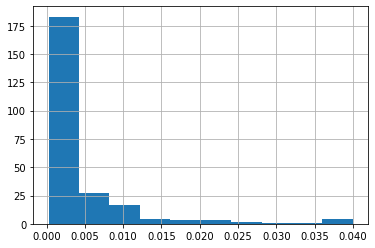

In [35]:
models_train.hist()
models_train.describe()

In [36]:
models_train = models_train.apply(lambda x: round(x, 2))

In [37]:
df_models_train = models_train.reset_index()
popular_models_train = []
for counter, model in enumerate(df_models_train['index']):
    if df_models_train['model_name'][counter] > 0:
        popular_models_train.append(model)

In [38]:
len(popular_models_train)

56

In [42]:
train_data['model_name'] = train_data['model_name'].map(lambda x: 'Popular' if x in popular_models_train else 'Other' )

train_data['Popular_model'] = train_data['model_name'].apply(fill_Popular_model)

train_data.drop(['model_name'], inplace = True, axis = 1)

### `numberOfDoors`

In [40]:
#fill numberOfDoors
for counter, offer in enumerate(data):
    if offer['vehicle_info']['configuration']['doors_count']:
        variable = offer['vehicle_info']['configuration']['doors_count']
        train_data.loc[counter, 'numberOfDoors'] = variable
    else:
        train_data.loc[counter, 'numberOfDoors'] = None

In [43]:
train_data.numberOfDoors.unique()

array([4., 5., 2., 3.])

### `price`

In [44]:
#fill price
for counter, offer in enumerate(data):
    if offer['price_info'] != {}:
        variable = offer['price_info']['price']
        train_data.loc[counter, 'price'] = variable
    else:
        train_data.loc[counter, 'price'] = None

count     3774.000000
mean      2359.883413
std       2571.493122
min         80.000000
25%       1080.000000
50%       1730.000000
75%       2860.000000
max      80800.000000
Name: price, dtype: float64

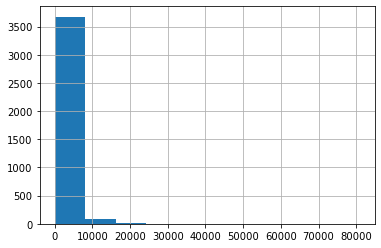

In [45]:
(train_data['price']/1000).hist()
(train_data['price']/1000).describe()

In [46]:
# Fill missing values with median price
train_data['price'] = train_data['price'].fillna(1730000) 

### `productionDate`

In [47]:
#fill productionDate
for counter, offer in enumerate(data):
    if offer['documents']['year']:
        variable = offer['documents']['year']
        train_data.loc[counter, 'productionDate'] = variable
    else:
        train_data.loc[counter, 'productionDate'] = None

### `sell_id`

In [48]:
#fill sell_id
for counter, offer in enumerate(data):
    if offer['id']:
        variable = offer['id']
        train_data.loc[counter, 'sell_id'] = variable
    else:
        train_data.loc[counter, 'sell_id'] = None

### `vehicleTransmission`

In [49]:
#fill vehicleTransmission
for counter, offer in enumerate(data):
    if offer['vehicle_info']['tech_param']['transmission']:
        variable = offer['vehicle_info']['tech_param']['transmission']
        train_data.loc[counter, 'vehicleTransmission'] = variable
    else:
        train_data.loc[counter, 'vehicleTransmission'] = None

In [50]:
train_data.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'VARIATOR', 'ROBOT'], dtype=object)

### `vendor`

In [51]:
#fill vendor
for counter, offer in enumerate(data):
    if offer['vehicle_info']['vendor']:
        variable = offer['vehicle_info']['vendor']
        train_data.loc[counter, 'vendor'] = variable
    else:
        train_data.loc[counter, 'vendor'] = None

In [52]:
train_data.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

### `owners_number`

In [53]:
#fill owners_number
for counter, offer in enumerate(data):
    if offer['documents']['owners_number']:
        variable = offer['documents']['owners_number']
        train_data.loc[counter, 'owners_number'] = variable
    else:
        train_data.loc[counter, 'owners_number'] = None

### `original_registration`

In [54]:
#fill original_registration
for counter, offer in enumerate(data):
    if offer['documents']['pts']:
        variable = offer['documents']['pts']
        train_data.loc[counter, 'original_registration'] = variable
    else:
        train_data.loc[counter, 'original_registration'] = None

In [55]:
def fill_pts(car):
    if car == 'ORIGINAL':
        return 1
    else:
        return 0

In [56]:
train_data['original_registration'] = train_data['original_registration'].apply(fill_pts)

### `gear_type`

In [57]:
#fill gear_type	
for counter, offer in enumerate(data):
    if offer['vehicle_info']['tech_param']['gear_type']:
        variable = offer['vehicle_info']['tech_param']['gear_type']
        train_data.loc[counter, 'gearType'] = variable
    else:
        train_data.loc[counter, 'gearType'] = None

In [58]:
train_data.gearType.unique()

array(['REAR_DRIVE', 'FORWARD_CONTROL', 'ALL_WHEEL_DRIVE'], dtype=object)

### `steering_wheel`

In [59]:
#fill steering_wheel
for counter, offer in enumerate(data):
    if offer['vehicle_info']['steering_wheel']:
        variable = offer['vehicle_info']['steering_wheel']
        train_data.loc[counter, 'steering_wheel'] = variable
    else:
        train_data.loc[counter, 'steering_wheel'] = None

# Take a look at the train data

In [60]:
train_data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,original_registration,gearType,steering_wheel,price,Popular_model
0,MINIVAN,MERCEDES,BLACK,2.1,163.0,DIESEL,132000.0,2010.0,4.0,2013.0,1105117069,MECHANICAL,EUROPEAN,3.0,1,REAR_DRIVE,LEFT,2310000.0,0
1,SEDAN,TOYOTA,WHITE,3.5,249.0,GASOLINE,1000.0,2020.0,4.0,2021.0,1105798969,AUTOMATIC,JAPANESE,1.0,1,FORWARD_CONTROL,LEFT,3730000.0,0
2,SEDAN,NISSAN,BLUE,1.6,102.0,GASOLINE,292000.0,2012.0,4.0,2018.0,1105194592,MECHANICAL,JAPANESE,1.0,1,FORWARD_CONTROL,LEFT,550000.0,0
3,ALLROAD,LEXUS,BLACK,3.5,263.0,HYBRID,1000.0,2019.0,5.0,2021.0,1104950374,VARIATOR,JAPANESE,1.0,1,ALL_WHEEL_DRIVE,LEFT,4650000.0,0
4,LIFTBACK,SKODA,GRAY,1.8,150.0,GASOLINE,159000.0,2000.0,5.0,2007.0,1104636339,AUTOMATIC,EUROPEAN,2.0,1,FORWARD_CONTROL,LEFT,340000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,ALLROAD,INFINITI,BLACK,3.7,333.0,GASOLINE,134000.0,2011.0,5.0,2012.0,1105787067,AUTOMATIC,JAPANESE,4.0,1,ALL_WHEEL_DRIVE,LEFT,1880000.0,0
3871,SEDAN,TOYOTA,BLACK,2.5,178.0,HYBRID,9000.0,2017.0,4.0,2021.0,1105953941,VARIATOR,JAPANESE,1.0,1,ALL_WHEEL_DRIVE,LEFT,3310000.0,0
3872,ALLROAD,BMW,WHITE,3.0,306.0,GASOLINE,114000.0,2010.0,5.0,2013.0,1105817274,AUTOMATIC,EUROPEAN,3.0,1,ALL_WHEEL_DRIVE,LEFT,2170000.0,0
3873,SEDAN,MERCEDES,BLACK,1.9,194.0,DIESEL,26000.0,2020.0,4.0,2020.0,1105920887,AUTOMATIC,EUROPEAN,1.0,1,REAR_DRIVE,LEFT,5210000.0,0


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3875 entries, 0 to 3874
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               3875 non-null   object 
 1   brand                  3875 non-null   object 
 2   color                  3875 non-null   object 
 3   engineDisplacement     3875 non-null   float64
 4   enginePower            3875 non-null   float64
 5   fuelType               3875 non-null   object 
 6   mileage                3875 non-null   float64
 7   modelDate              3875 non-null   float64
 8   numberOfDoors          3875 non-null   float64
 9   productionDate         3875 non-null   float64
 10  sell_id                3875 non-null   object 
 11  vehicleTransmission    3875 non-null   object 
 12  vendor                 3875 non-null   object 
 13  owners_number          3875 non-null   float64
 14  original_registration  3875 non-null   int64  
 15  gear

## Train Data parsed by a team mate 

In [62]:
train_data_Tatyana = pd.read_csv('car_train_Tatyana.csv')

In [63]:
train_data_Tatyana.head(15)

,bodyType,brand,model_name,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,...,vehicleTransmission,vendor,acceleration,clearance_min,fuel_rate,owners_number,original_registration,gearType,steering_wheel,price
0,ALLROAD_5_DOORS,BMW,X5,040001,4619,347,GASOLINE,151151,1999,5,...,AUTOMATIC,EUROPEAN,6.5,180,14.9,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1188000
1,ALLROAD_5_DOORS,BMW,X5,040001,2993,218,DIESEL,480000,2003,5,...,AUTOMATIC,EUROPEAN,8.8,203,9.4,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,855000
2,ALLROAD_5_DOORS,BMW,X5,97948F,2979,231,GASOLINE,303000,1999,5,...,AUTOMATIC,EUROPEAN,8.8,180,12.9,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,720000
3,SEDAN,BMW,5ER,0000CC,2494,192,GASOLINE,315000,2000,4,...,MECHANICAL,EUROPEAN,8.1,120,9.4,4,DUPLICATE,REAR_DRIVE,LEFT,200000
4,SEDAN,BMW,5ER,007F00,2494,192,GASOLINE,302543,2000,4,...,AUTOMATIC,EUROPEAN,8.9,120,10.3,3,DUPLICATE,REAR_DRIVE,LEFT,395000
5,SEDAN,BMW,5ER,0000CC,2494,170,GASOLINE,300000,1995,4,...,MECHANICAL,EUROPEAN,8.5,120,9.7,4,DUPLICATE,REAR_DRIVE,LEFT,275000
6,SEDAN,BMW,5ER,4A2197,1991,150,GASOLINE,466000,1987,4,...,AUTOMATIC,EUROPEAN,11.7,120,9,4,ORIGINAL,REAR_DRIVE,LEFT,400000
7,SEDAN,BMW,3ER,040001,2793,193,GASOLINE,315000,1998,4,...,AUTOMATIC,EUROPEAN,8.1,130,10.1,4,DUPLICATE,REAR_DRIVE,LEFT,900000
8,SEDAN,BMW,5ER,0000CC,2494,170,GASOLINE,500000,1995,4,...,MECHANICAL,EUROPEAN,8.5,120,9.7,4,DUPLICATE,REAR_DRIVE,LEFT,240000
9,ALLROAD_5_DOORS,BMW,X5,97948F,2979,231,GASOLINE,245000,2003,5,...,AUTOMATIC,EUROPEAN,8.8,203,12.9,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,795000


In [64]:
train_data_Tatyana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30187 entries, 0 to 30186
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bodyType                   30187 non-null  object
 1   brand                      30187 non-null  object
 2   model_name                 30187 non-null  object
 3   color                      30187 non-null  object
 4   engineDisplacement         30187 non-null  int64 
 5   enginePower                30187 non-null  int64 
 6   fuelType                   30187 non-null  object
 7   mileage                    30187 non-null  int64 
 8    modelDate                 30187 non-null  int64 
 9   numberOfDoors              30187 non-null  int64 
 10  productionDate             30187 non-null  int64 
 11   sell_id                   30187 non-null  int64 
 12   vehicleTransmission       30187 non-null  object
 13   vendor                    30187 non-null  object
 14   accel

In [65]:
train_data_Tatyana.columns

Index(['bodyType', 'brand', 'model_name', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', ' modelDate', 'numberOfDoors',
       'productionDate', ' sell_id', ' vehicleTransmission', ' vendor',
       ' acceleration', ' clearance_min', ' fuel_rate', 'owners_number',
       '    original_registration', ' gearType', ' steering_wheel', ' price'],
      dtype='object')

In [66]:
new_columns = ['bodyType', 'brand', 'model_name', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'numberOfDoors',
       'productionDate', 'sell_id', 'vehicleTransmission', 'vendor',
       'acceleration', 'clearance_min', 'fuel_rate', 'owners_number',
       'original_registration', 'gearType', 'steering_wheel', 'price']

In [67]:
train_data_Tatyana.columns = new_columns

### bodyType

In [68]:
train_data_Tatyana.bodyType.unique()

array(['ALLROAD_5_DOORS', 'SEDAN', 'WAGON_5_DOORS', 'HATCHBACK_3_DOORS',
       'COUPE', 'CABRIO', 'HATCHBACK_5_DOORS', 'COUPE_HARDTOP',
       'ROADSTER', 'LIFTBACK', 'COMPACTVAN', 'MINIVAN', 'VAN',
       'PICKUP_TWO', 'PICKUP_ONE', 'ALLROAD_3_DOORS', 'MICROVAN',
       'LIMOUSINE', 'ALLROAD_OPEN', 'SEDAN_HARDTOP', 'PICKUP_ONE_HALF',
       'TARGA'], dtype=object)

In [69]:
train_data_Tatyana['bodyType'] = train_data_Tatyana['bodyType'].apply(fill_bodyType)

### brand

In [70]:
train_data_Tatyana.brand.unique()

array(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI',
       'MITSUBISHI', 'SKODA', 'HONDA', 'INFINITI', 'LEXUS', 'VOLVO'],
      dtype=object)

### model_name

In [71]:
len(train_data_Tatyana.model_name.unique())

511

In [72]:
models_Tatyana = train_data_Tatyana.model_name.value_counts(normalize=True)
models_Tatyana

OCTAVIA     0.033027
E_KLASSE    0.032630
5ER         0.031404
POLO        0.025475
3ER         0.024050
              ...   
BEAT        0.000033
ENDEAVOR    0.000033
IST         0.000033
POLO_GTI    0.000033
DION        0.000033
Name: model_name, Length: 511, dtype: float64

count    511.000000
mean       0.001957
std        0.004510
min        0.000033
25%        0.000099
50%        0.000265
75%        0.001441
max        0.033027
Name: model_name, dtype: float64

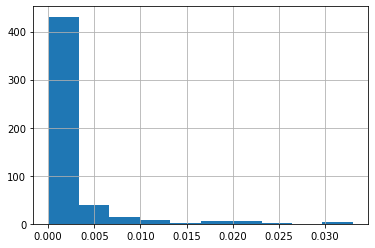

In [73]:
models_Tatyana.hist()
models_Tatyana.describe()

In [74]:
models_Tatyana = models_Tatyana.apply(lambda x: round(x, 2))

In [75]:
df_models_Tatyana = models_Tatyana.reset_index()
popular_models_Tatyana = []
for counter, model in enumerate(df_models_Tatyana['index']):
    if df_models_Tatyana['model_name'][counter] > 0:
        popular_models_Tatyana.append(model)

In [76]:
train_data_Tatyana['model_name'] = train_data_Tatyana['model_name'].map(lambda x: 'Popular' if x in popular_models_Tatyana else 'Other' )

train_data_Tatyana['Popular_model'] = train_data_Tatyana['model_name'].apply(fill_Popular_model)

train_data_Tatyana.drop(['model_name'], inplace = True, axis = 1)


### color

In [77]:
train_data_Tatyana.color.unique()

array(['040001', '97948F', '0000CC', '007F00', '4A2197', 'CACECB',
       'FAFBFB', 'EE1D19', '22A0F8', '660099', 'C49648', 'DEA522',
       'FFD600', '200204', 'FF8649', 'FFC0CB'], dtype=object)

In [78]:
def fill_color(car):
    if car == '0000CC':
        return 'BLUE'
    elif car == "040001":
        return 'BLACK'
    elif car == "200204":
        return 'BLACK'
    elif car == "97948F":
        return 'GRAY'
    elif car == "FAFBFB":
        return 'WHITE'
    elif car == "CACECB":
        return 'SILVER'
    elif car == "EE1D19":
        return 'RED'
    elif car == "007F00":
        return 'GREEN'
    elif car == "FFD600":
        return 'YELLOW'
    elif car == "22A0F8":
        return 'LIGHT_BLUE'
    elif car == "FF8649":
        return 'ORANGE'
    elif car == "660099":
        return 'PURPLE'
    elif car == "4A2197":
        return 'PURPLE'
    elif car == "C49648":
        return 'GOLDEN'
    elif car == "DEA522":
        return 'GOLDEN'
    elif car == "FFC0CB":
        return 'PINK'

In [79]:
train_data_Tatyana['color'] = train_data_Tatyana['color'].apply(fill_color)

### engineDisplacement

In [80]:
train_data_Tatyana['engineDisplacement'] = train_data_Tatyana['engineDisplacement'].map(lambda x: round(x/1000, 1) )

### price

In [81]:
len(train_data_Tatyana[train_data_Tatyana.price == 'None'])

79

In [82]:
train_data_Tatyana['price'] = train_data_Tatyana['price'].map(lambda x: '0' if x == 'None' else x )


In [83]:
train_data_Tatyana['price'] = train_data_Tatyana['price'].map(lambda x: int(x) )

In [84]:
(train_data_Tatyana[train_data_Tatyana['price'] > 0]['price']/1000).describe()

count    30108.000000
mean      1806.258665
std       2065.868062
min         35.000000
25%        680.000000
50%       1270.000000
75%       2220.000000
max      80000.000000
Name: price, dtype: float64

In [85]:
train_data_Tatyana['price'] = train_data_Tatyana['price'].map(lambda x: 1270000 if x == 0 else x )

### owners_number

In [86]:
train_data_Tatyana['owners_number'] = train_data_Tatyana['owners_number'].map(lambda x: None if x == 'None' else x )


In [87]:
train_data_Tatyana['owners_number'] = train_data_Tatyana['owners_number'].fillna(0) 

In [88]:
train_data_Tatyana['owners_number'] = train_data_Tatyana['owners_number'].map(lambda x: int(x) )

In [89]:
train_data_Tatyana.owners_number.unique()

array([3, 2, 4, 1, 0])

### original_registration

In [90]:
train_data_Tatyana.original_registration.unique()

array(['ORIGINAL', 'DUPLICATE', 'None'], dtype=object)

In [91]:
len(train_data_Tatyana[train_data_Tatyana.original_registration == 'None'])

4

In [92]:
train_data_Tatyana['original_registration'] = train_data_Tatyana['original_registration'].map(lambda x: 'ORIGINAL' if x == 'None' else x )



In [93]:
train_data_Tatyana['original_registration'] = train_data_Tatyana['original_registration'].apply(fill_pts)

Take a look one more time

In [94]:
train_data_Tatyana.head(15)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,...,vendor,acceleration,clearance_min,fuel_rate,owners_number,original_registration,gearType,steering_wheel,price,Popular_model
0,ALLROAD,BMW,BLACK,4.6,347,GASOLINE,151151,1999,5,2003,...,EUROPEAN,6.5,180,14.9,3,1,ALL_WHEEL_DRIVE,LEFT,1188000,1
1,ALLROAD,BMW,BLACK,3.0,218,DIESEL,480000,2003,5,2004,...,EUROPEAN,8.8,203,9.4,2,1,ALL_WHEEL_DRIVE,LEFT,855000,1
2,ALLROAD,BMW,GRAY,3.0,231,GASOLINE,303000,1999,5,2002,...,EUROPEAN,8.8,180,12.9,3,1,ALL_WHEEL_DRIVE,LEFT,720000,1
3,SEDAN,BMW,BLUE,2.5,192,GASOLINE,315000,2000,4,2003,...,EUROPEAN,8.1,120,9.4,4,0,REAR_DRIVE,LEFT,200000,1
4,SEDAN,BMW,GREEN,2.5,192,GASOLINE,302543,2000,4,2002,...,EUROPEAN,8.9,120,10.3,3,0,REAR_DRIVE,LEFT,395000,1
5,SEDAN,BMW,BLUE,2.5,170,GASOLINE,300000,1995,4,1999,...,EUROPEAN,8.5,120,9.7,4,0,REAR_DRIVE,LEFT,275000,1
6,SEDAN,BMW,PURPLE,2.0,150,GASOLINE,466000,1987,4,1995,...,EUROPEAN,11.7,120,9,4,1,REAR_DRIVE,LEFT,400000,1
7,SEDAN,BMW,BLACK,2.8,193,GASOLINE,315000,1998,4,2000,...,EUROPEAN,8.1,130,10.1,4,0,REAR_DRIVE,LEFT,900000,1
8,SEDAN,BMW,BLUE,2.5,170,GASOLINE,500000,1995,4,1996,...,EUROPEAN,8.5,120,9.7,4,0,REAR_DRIVE,LEFT,240000,1
9,ALLROAD,BMW,GRAY,3.0,231,GASOLINE,245000,2003,5,2004,...,EUROPEAN,8.8,203,12.9,2,1,ALL_WHEEL_DRIVE,LEFT,795000,1


In [95]:
train_data_Tatyana.drop(['acceleration', 'clearance_min', 'fuel_rate'], inplace = True, axis = 1)

In [96]:
train_data_Tatyana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30187 entries, 0 to 30186
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               30187 non-null  object 
 1   brand                  30187 non-null  object 
 2   color                  30187 non-null  object 
 3   engineDisplacement     30187 non-null  float64
 4   enginePower            30187 non-null  int64  
 5   fuelType               30187 non-null  object 
 6   mileage                30187 non-null  int64  
 7   modelDate              30187 non-null  int64  
 8   numberOfDoors          30187 non-null  int64  
 9   productionDate         30187 non-null  int64  
 10  sell_id                30187 non-null  int64  
 11  vehicleTransmission    30187 non-null  object 
 12  vendor                 30187 non-null  object 
 13  owners_number          30187 non-null  int64  
 14  original_registration  30187 non-null  int64  
 15  ge

# Merge dataframes

In [97]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3875 entries, 0 to 3874
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               3875 non-null   object 
 1   brand                  3875 non-null   object 
 2   color                  3875 non-null   object 
 3   engineDisplacement     3875 non-null   float64
 4   enginePower            3875 non-null   float64
 5   fuelType               3875 non-null   object 
 6   mileage                3875 non-null   float64
 7   modelDate              3875 non-null   float64
 8   numberOfDoors          3875 non-null   float64
 9   productionDate         3875 non-null   float64
 10  sell_id                3875 non-null   object 
 11  vehicleTransmission    3875 non-null   object 
 12  vendor                 3875 non-null   object 
 13  owners_number          3875 non-null   float64
 14  original_registration  3875 non-null   int64  
 15  gear

In [98]:
train_data_Tatyana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30187 entries, 0 to 30186
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               30187 non-null  object 
 1   brand                  30187 non-null  object 
 2   color                  30187 non-null  object 
 3   engineDisplacement     30187 non-null  float64
 4   enginePower            30187 non-null  int64  
 5   fuelType               30187 non-null  object 
 6   mileage                30187 non-null  int64  
 7   modelDate              30187 non-null  int64  
 8   numberOfDoors          30187 non-null  int64  
 9   productionDate         30187 non-null  int64  
 10  sell_id                30187 non-null  int64  
 11  vehicleTransmission    30187 non-null  object 
 12  vendor                 30187 non-null  object 
 13  owners_number          30187 non-null  int64  
 14  original_registration  30187 non-null  int64  
 15  ge

In [99]:
total_train = pd.concat([train_data, train_data_Tatyana])

In [100]:
total_train.drop_duplicates(subset = 'sell_id', keep = 'first', inplace = True)

In [101]:
total_train.head(10)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,original_registration,gearType,steering_wheel,price,Popular_model
0,MINIVAN,MERCEDES,BLACK,2.1,163.0,DIESEL,132000.0,2010.0,4.0,2013.0,1105117069,MECHANICAL,EUROPEAN,3.0,1,REAR_DRIVE,LEFT,2310000.0,0
1,SEDAN,TOYOTA,WHITE,3.5,249.0,GASOLINE,1000.0,2020.0,4.0,2021.0,1105798969,AUTOMATIC,JAPANESE,1.0,1,FORWARD_CONTROL,LEFT,3730000.0,0
2,SEDAN,NISSAN,BLUE,1.6,102.0,GASOLINE,292000.0,2012.0,4.0,2018.0,1105194592,MECHANICAL,JAPANESE,1.0,1,FORWARD_CONTROL,LEFT,550000.0,0
3,ALLROAD,LEXUS,BLACK,3.5,263.0,HYBRID,1000.0,2019.0,5.0,2021.0,1104950374,VARIATOR,JAPANESE,1.0,1,ALL_WHEEL_DRIVE,LEFT,4650000.0,0
4,LIFTBACK,SKODA,GRAY,1.8,150.0,GASOLINE,159000.0,2000.0,5.0,2007.0,1104636339,AUTOMATIC,EUROPEAN,2.0,1,FORWARD_CONTROL,LEFT,340000.0,0
5,SEDAN,VOLKSWAGEN,SILVER,1.6,105.0,GASOLINE,163000.0,2009.0,4.0,2012.0,1105736212,MECHANICAL,EUROPEAN,3.0,1,FORWARD_CONTROL,LEFT,440000.0,0
6,ALLROAD,LEXUS,BLUE,2.7,188.0,GASOLINE,204000.0,2012.0,5.0,2012.0,1105684832,AUTOMATIC,JAPANESE,4.0,1,FORWARD_CONTROL,LEFT,1900000.0,0
7,ALLROAD,BMW,BLUE,4.4,555.0,GASOLINE,157000.0,2009.0,5.0,2011.0,1102877847,AUTOMATIC,EUROPEAN,4.0,1,ALL_WHEEL_DRIVE,LEFT,1820000.0,0
8,SEDAN,NISSAN,BLUE,1.6,107.0,GASOLINE,241000.0,2006.0,4.0,2006.0,1105445599,MECHANICAL,JAPANESE,4.0,1,FORWARD_CONTROL,LEFT,260000.0,0
9,ALLROAD,NISSAN,BLACK,2.0,141.0,GASOLINE,196000.0,2010.0,5.0,2011.0,1105143586,VARIATOR,JAPANESE,3.0,1,ALL_WHEEL_DRIVE,LEFT,960000.0,0


In [102]:
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33841 entries, 0 to 30186
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               33841 non-null  object 
 1   brand                  33841 non-null  object 
 2   color                  33841 non-null  object 
 3   engineDisplacement     33841 non-null  float64
 4   enginePower            33841 non-null  float64
 5   fuelType               33841 non-null  object 
 6   mileage                33841 non-null  float64
 7   modelDate              33841 non-null  float64
 8   numberOfDoors          33841 non-null  float64
 9   productionDate         33841 non-null  float64
 10  sell_id                33841 non-null  object 
 11  vehicleTransmission    33841 non-null  object 
 12  vendor                 33841 non-null  object 
 13  owners_number          33841 non-null  float64
 14  original_registration  33841 non-null  int64  
 15  ge

In [103]:
# export to csv
total_train.to_csv("total_train.csv")

## Exploratory data analysis (EDA)

### engineDisplacement

count    33841.000000
mean         2.452327
std          0.997265
min          0.000000
25%          1.800000
50%          2.000000
75%          3.000000
max          6.600000
Name: engineDisplacement, dtype: float64

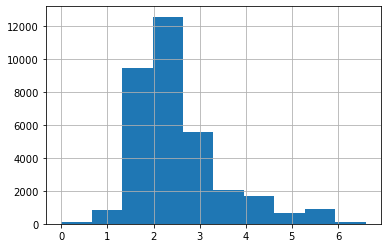

In [2287]:
total_train.engineDisplacement.hist()
total_train.engineDisplacement.describe()

We see that electric cars have zero engine capacity, the distribution is similar to normal, most cars have an engine capacity between 1.5 and 2.5 liters

### enginePower

count    33841.000000
mean       199.107650
std         95.364087
min         45.000000
25%        140.000000
50%        178.000000
75%        245.000000
max        800.000000
Name: enginePower, dtype: float64

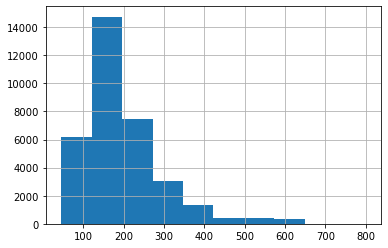

In [2288]:
total_train.enginePower.hist()
total_train.enginePower.describe()

In [2289]:
total_train[total_train.enginePower == total_train.enginePower.max()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,original_registration,gearType,steering_wheel,price,Popular_model
511,ALLROAD,MERCEDES,GRAY,4.0,800.0,GASOLINE,3000.0,2018.0,5.0,2021.0,1105200476,AUTOMATIC,EUROPEAN,1.0,1,ALL_WHEEL_DRIVE,LEFT,21900000.0,0


In [2290]:
total_train[total_train.enginePower == total_train.enginePower.min()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,original_registration,gearType,steering_wheel,price,Popular_model
27378,MICROVAN,HONDA,GRAY,0.7,45.0,GASOLINE,240000.0,1999.0,4.0,2010.0,1105473047,MECHANICAL,JAPANESE,1.0,1,ALL_WHEEL_DRIVE,RIGHT,500000.0,0


The distribution is similar to normal, cars which have minimal and maximal engine capacities have corresponding technical characteristics 

### mileage

count      33841.000000
mean      152693.331462
std       100553.067488
min            0.000000
25%        79000.000000
50%       138303.000000
75%       205000.000000
max      1000000.000000
Name: mileage, dtype: float64

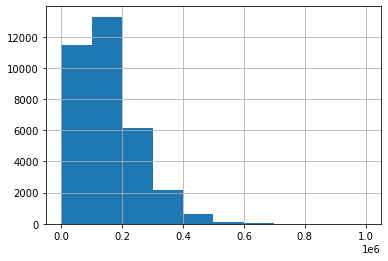

In [2291]:
total_train.mileage.hist()
total_train.mileage.describe()

In [2292]:
len(total_train[total_train.mileage == 0])

95

We see that there is a small number of new cars in the data

### modelDate

In [2293]:
sorted(total_train.modelDate.unique())

[1974.0,
 1979.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

In [2294]:
total_train.modelDate.value_counts(normalize=True)

2013.0    0.078426
2014.0    0.076593
2015.0    0.071895
2010.0    0.068674
2011.0    0.068054
2012.0    0.063178
2017.0    0.062823
2009.0    0.056470
2008.0    0.052215
2006.0    0.048078
2005.0    0.040661
2007.0    0.039006
2016.0    0.035815
2018.0    0.023285
2002.0    0.021306
2000.0    0.019503
2003.0    0.019444
2004.0    0.018616
2019.0    0.015130
1999.0    0.013770
1995.0    0.012618
2020.0    0.012559
1998.0    0.011790
1997.0    0.010490
2001.0    0.009751
1996.0    0.008304
1991.0    0.008008
1994.0    0.007594
1990.0    0.005940
1992.0    0.004758
1988.0    0.003576
1987.0    0.003132
1993.0    0.003103
1989.0    0.001448
1984.0    0.001300
1986.0    0.000975
1982.0    0.000502
1983.0    0.000414
1985.0    0.000384
2021.0    0.000177
1974.0    0.000118
1979.0    0.000089
1981.0    0.000030
Name: modelDate, dtype: float64

The data contains car models from 1974 to 2021, car models are distributed approximately evenly by year

### numberOfDoors

In [2295]:
total_train.numberOfDoors.unique()

array([4., 5., 2., 3.])

### productionDate

In [2296]:
sorted(total_train.productionDate.unique())

[1987.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

In [2297]:
total_train.productionDate.value_counts(normalize=True)

2012.0    0.079164
2013.0    0.074052
2018.0    0.071068
2014.0    0.070358
2011.0    0.065955
2017.0    0.062853
2016.0    0.061405
2015.0    0.060282
2008.0    0.056913
2019.0    0.052067
2020.0    0.046246
2010.0    0.045271
2007.0    0.040661
2006.0    0.025679
2009.0    0.022960
2005.0    0.019089
2004.0    0.017494
2003.0    0.014568
2001.0    0.014391
2002.0    0.013652
1998.0    0.013061
1999.0    0.011554
2000.0    0.011022
1997.0    0.010047
1996.0    0.007003
1992.0    0.005821
1993.0    0.005792
1991.0    0.004639
1994.0    0.004639
1995.0    0.004610
2021.0    0.004492
1990.0    0.003073
1987.0    0.000089
1989.0    0.000030
Name: productionDate, dtype: float64

The data contains cars produced from 1987 to 2021, the cars are distributed approximately evenly by year

### owners_number

In [2298]:
total_train.owners_number.unique()

array([3., 1., 2., 4., 0.])

### price

count    33841.000000
mean      1864.469546
std       2130.793707
min         35.000000
25%        719.000000
50%       1319.000000
75%       2299.000000
max      80800.000000
Name: price, dtype: float64

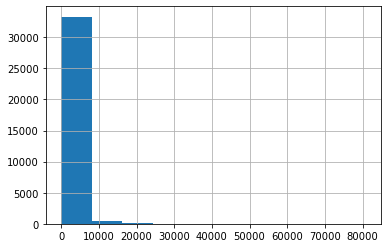

In [2299]:
(total_train['price']/1000).hist()
(total_train['price']/1000).describe()

Let's bring the prices of November 2021 to the prices for October 2020. To do this, multiply the prices by the inflation rate from the beginning of 2021 (The inflation rate from the beginning of 2021: 6.49%)

In [2300]:
total_train['price'] = total_train['price'].map(lambda x: x*0.9351 )

<AxesSubplot:>

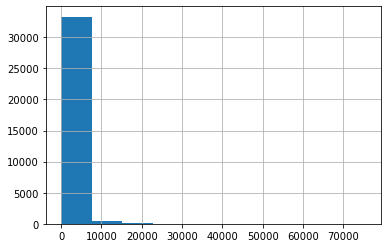

In [2301]:
(total_train['price']/1000).hist()

Our distribution has a problem — the difference between prices is too strong. There are many cars in the middle segment, but very few expensive cars. Let's logarithm the variable to reduce the differences and smooth out the tail.

<AxesSubplot:>

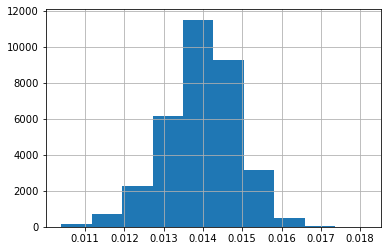

In [2302]:
total_train['price'] = total_train['price'].apply(lambda w: np.log(w + 1))
(total_train['price']/1000).hist()

## Analysis of nominative variables

### bodyType

In [2303]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='price', 
                data=total_train.loc[total_train.loc[:, column].isin(total_train.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

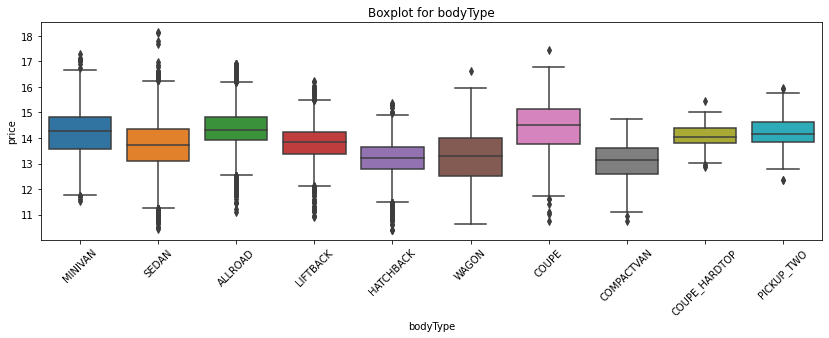

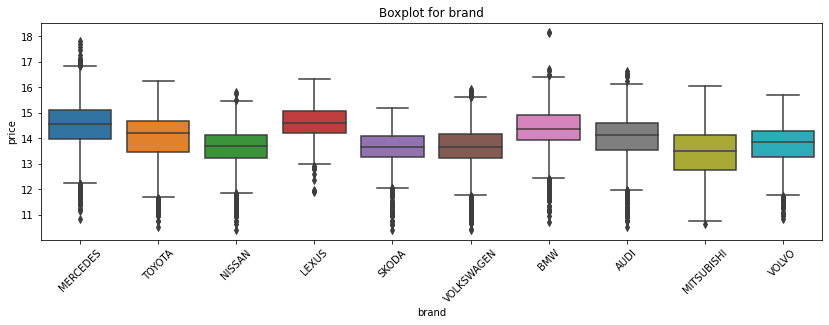

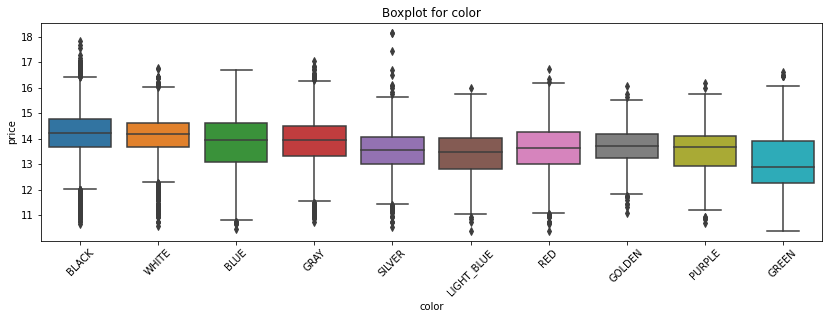

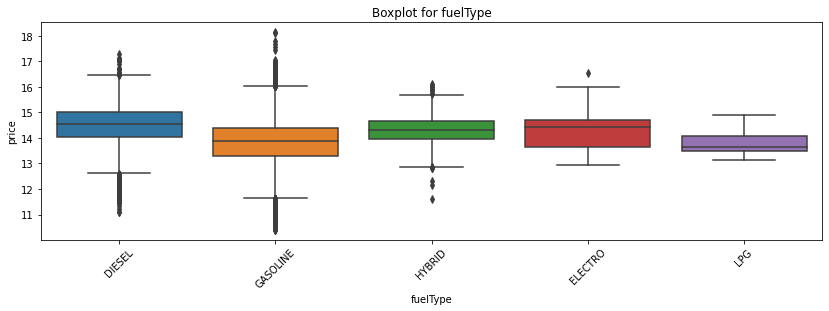

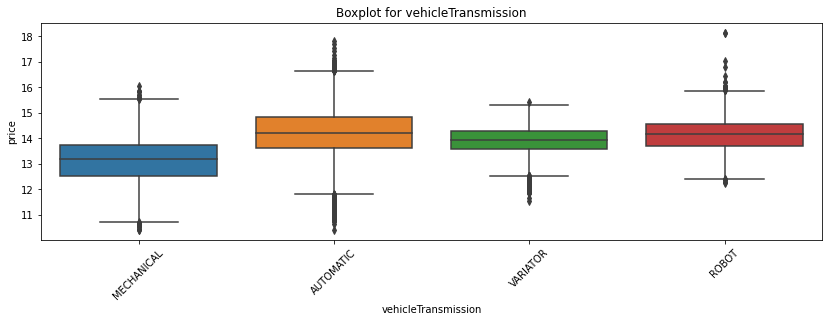

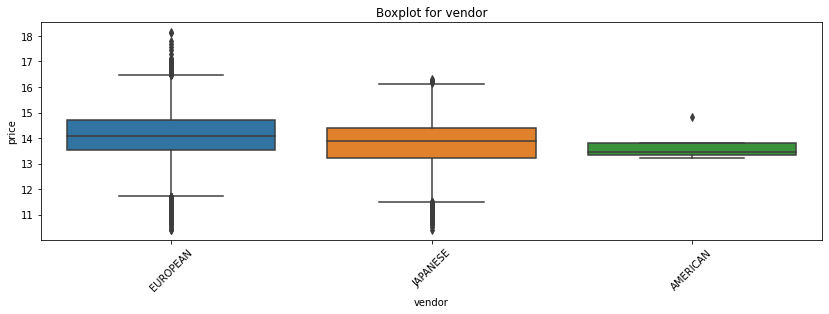

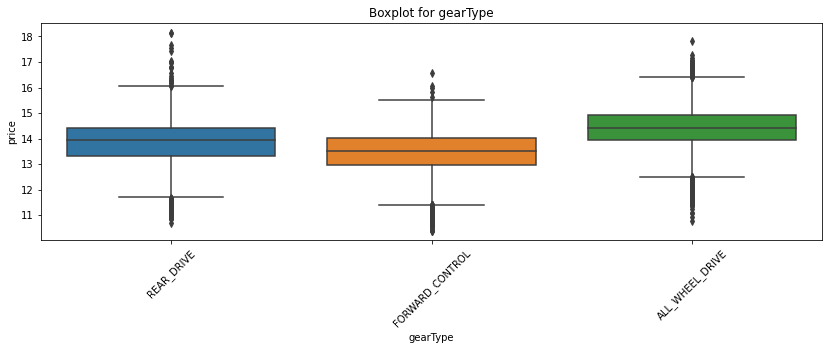

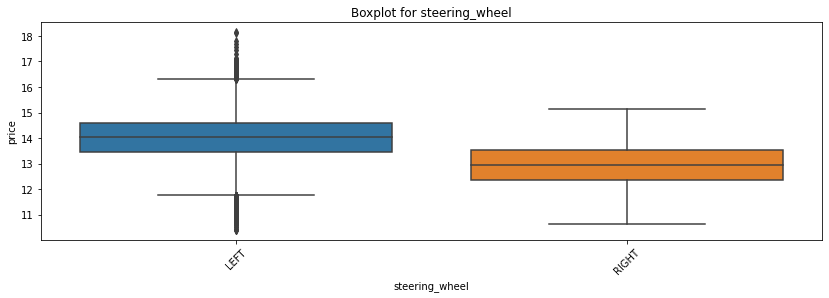

In [2304]:
for col in ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'vendor', 'gearType', 'steering_wheel']:
    get_boxplot(col)

According to the charts, it looks like all the parameters can affect the price of the car. However, graphs are only an auxiliary tool, statistics can help to recognize the real significance of differences. Let's check whether there is a statistical difference in the distribution of prices by nominative feature using the Student's test. Let's test the null hypothesis that the price distributions of cars by various parameters are indistinguishable:

In [2305]:
def get_stat_dif(column):
    cols = total_train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(total_train.loc[total_train.loc[:, column] == comb[0], 'price'], 
                        total_train.loc[total_train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Statistically significant differences were found for the column: ', column)
            break

In [2306]:
for col in ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'vendor', 'gearType', 'steering_wheel']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки vendor
Найдены статистически значимые различия для колонки gearType
Найдены статистически значимые различия для колонки steering_wheel


As we can see, significant statistical differences were found in all columns. We will leave all variables in the dataset for the model

## Correlation analysis

In [2307]:
correlation = total_train.corr()

<AxesSubplot:>

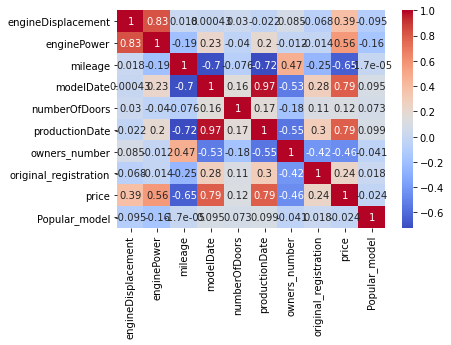

In [2308]:
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

Let's remove strongly correlated columns

In [2309]:
total_train.drop(['engineDisplacement', 'modelDate', 'owners_number'], inplace = True, axis = 1)

In [2310]:
total_train

,bodyType,brand,color,enginePower,fuelType,mileage,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,original_registration,gearType,steering_wheel,price,Popular_model
0,MINIVAN,MERCEDES,BLACK,163.0,DIESEL,132000.0,4.0,2013.0,1105117069,MECHANICAL,EUROPEAN,1,REAR_DRIVE,LEFT,14.585657,0
1,SEDAN,TOYOTA,WHITE,249.0,GASOLINE,1000.0,4.0,2021.0,1105798969,AUTOMATIC,JAPANESE,1,FORWARD_CONTROL,LEFT,15.064817,1
2,SEDAN,NISSAN,BLUE,102.0,GASOLINE,292000.0,4.0,2018.0,1105194592,MECHANICAL,JAPANESE,1,FORWARD_CONTROL,LEFT,13.150574,1
3,ALLROAD,LEXUS,BLACK,263.0,HYBRID,1000.0,5.0,2021.0,1104950374,VARIATOR,JAPANESE,1,ALL_WHEEL_DRIVE,LEFT,15.285276,1
4,LIFTBACK,SKODA,GRAY,150.0,GASOLINE,159000.0,5.0,2007.0,1104636339,AUTOMATIC,EUROPEAN,1,FORWARD_CONTROL,LEFT,12.669602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30182,ALLROAD,VOLVO,BLACK,203.0,GASOLINE,138000.0,5.0,2011.0,1105195558,ROBOT,EUROPEAN,1,FORWARD_CONTROL,LEFT,13.888172,0
30183,SEDAN,VOLVO,BLACK,200.0,GASOLINE,218000.0,4.0,2000.0,1105894343,AUTOMATIC,EUROPEAN,1,FORWARD_CONTROL,LEFT,12.844543,0
30184,SEDAN,VOLVO,BLACK,140.0,GASOLINE,350000.0,4.0,2008.0,1105975953,AUTOMATIC,EUROPEAN,1,FORWARD_CONTROL,LEFT,13.347933,0
30185,SEDAN,VOLVO,BLUE,170.0,GASOLINE,351000.0,4.0,2004.0,1105448320,AUTOMATIC,EUROPEAN,1,FORWARD_CONTROL,LEFT,12.832121,0


In [2311]:
# Let's do one-hot encoding for some columns

total_train = pd.get_dummies(total_train, columns=['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'vendor', 'gearType', 'steering_wheel'])

total_train

,enginePower,mileage,numberOfDoors,productionDate,sell_id,original_registration,price,Popular_model,bodyType_ALLROAD,bodyType_ALLROAD_OPEN,...,vehicleTransmission_ROBOT,vehicleTransmission_VARIATOR,vendor_AMERICAN,vendor_EUROPEAN,vendor_JAPANESE,gearType_ALL_WHEEL_DRIVE,gearType_FORWARD_CONTROL,gearType_REAR_DRIVE,steering_wheel_LEFT,steering_wheel_RIGHT
0,163.0,132000.0,4.0,2013.0,1105117069,1,14.585657,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,249.0,1000.0,4.0,2021.0,1105798969,1,15.064817,1,0,0,...,0,0,0,0,1,0,1,0,1,0
2,102.0,292000.0,4.0,2018.0,1105194592,1,13.150574,1,0,0,...,0,0,0,0,1,0,1,0,1,0
3,263.0,1000.0,5.0,2021.0,1104950374,1,15.285276,1,1,0,...,0,1,0,0,1,1,0,0,1,0
4,150.0,159000.0,5.0,2007.0,1104636339,1,12.669602,1,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30182,203.0,138000.0,5.0,2011.0,1105195558,1,13.888172,0,1,0,...,1,0,0,1,0,0,1,0,1,0
30183,200.0,218000.0,4.0,2000.0,1105894343,1,12.844543,0,0,0,...,0,0,0,1,0,0,1,0,1,0
30184,140.0,350000.0,4.0,2008.0,1105975953,1,13.347933,0,0,0,...,0,0,0,1,0,0,1,0,1,0
30185,170.0,351000.0,4.0,2004.0,1105448320,1,12.832121,0,0,0,...,0,0,0,1,0,0,1,0,1,0
